# Linear Regression Implementation

In [15]:
import random
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *

np.random.seed(42) 

# **1. Linear Regression**

## **1.1. Linear Regression Implementation [15 pts, Autograded]**

In this section you will implement linear regression with both L1 and L2 regularization. Your class LinearRegression must implement the following API:

* `__init__(alpha, tol, max_iter, theta_init, penalty, lambd)`
* `compute_cost(theta, X, y)`
* `compute_gradient(theta, X, y)`
* `fit(X, y)`
* `has_converged(theta_old, theta_new)`
* `predict(X)`

Note that these methods have already been defined correctly for you in the LinearRegression class. **DO NOT** change the API.

### **1.1.1. Cost Function [5 pts]**

The `compute_cost` function should compute the cost for a given $\theta$ vector. The cost is a scalar value given by:

$
\mathcal{L}({\theta}) = \frac{1}{N}\sum_{i =1}^N (h_{{\theta}}({x}_i) - y_i)^2
$

where

> $h_{{\theta}}({x}_i) = \theta^Tx_i$

Based on the regularisation penalty, you may need to add below regularisation penalty loss to MSE Loss computed previously.

L1 Regularisation Loss:
>$
\mathcal{L_1}({\theta}) = \mathcal{L}({\theta}) + \lambda\sum_{j = 1}^D  |{\theta}_j|
$

L2 Regularisation Loss:
>$
\mathcal{L_2}({\theta}) = \mathcal{L}({\theta}) + \lambda\sum_{j = 1}^D  {\theta}_j^2
$

$N$ is the number of training samples and $D$ is the number of features (excluding the intercept term). $\theta$ is a $D + 1$ dimensional vector, with the first element being the intercept term. Note that we do not include the intercept in the regularization terms.

---

### **1.1.2. Gradient of the Cost Function [5 pts]**

The `compute_gradient` function should compute the gradient of the cost function at a given $\theta$.

---

### **1.1.3. Convergence Check [1 pt]**

The `has_converged` function should return whether gradient descent algorithm has converged or not. Refer 1.1.4 for convergence condition.

---

### **1.1.4. Training with Gradient Descent [3 pts]**

The `fit` method should train the model via gradient descent, relying on the cost and gradient functions. The trained weights/coefficients must be stored as `theta_`. The weights and the corresponding cost after every gradient descent iteration must be stored in `hist_theta_` and `hist_cost_` respectively.

* The gradient descent stops or converges when $\theta$ stops changing or changes negligibly between consecutive iterations, i.e., when
$\| {\theta}_\mathit{new} -  {\theta}_\mathit{old} \|_2 \leq \epsilon$,
for some small $\epsilon$ (e.g., $\epsilon$ = 1E-4). $\epsilon$ is stored as `tol` (short for tolerance).

* To ensure that the function terminates, we should set a maximum limit for the number of epochs irrespective of whether $\theta$ converges or not. The limit is stored as `max_iter`.

* `alpha` is the learning rate of the gradient descent algorithm.

---

### **1.1.5. Training with Stochastic Gradient Descent (SGD) [3 pts]**

The `fit_sgd` method should train the model via stochastic gradient descent (SGD), relying on the cost and gradient functions.

The trained weights/coefficients must be stored as `theta_`. The weights and the corresponding cost after every SGD iteration must be stored in `hist_theta_` and `hist_cost_` respectively.

* Unlike regular (or batch) gradient descent, SGD takes a gradient step on a single training example on each iteration. In other words, rather than compute the gradient for all training examples, summing them, and taking a single gradient step, it iterates through training examples, computes the gradient for that training example, and immediately takes a single gradient step before proceeding to the next training example. One pass over the entire training dataset is called an epoch; at the end of an epoch, the next epoch restarts from the first example in the training dataset.

* As with gradient descent, SGD stops or converges when $\theta$ stops changing or changes negligibly between consecutive iterations, i.e., when
$\| {\theta}_\mathit{new} -  {\theta}_\mathit{old} \|_2 \leq \epsilon$,
for some small $\epsilon$ (e.g., $\epsilon$ = 1E-4). $\epsilon$ is stored as `tol` (short for tolerance). Since each step is much shorter, SGD typically only checks for convergence at the end of each epoch.

* To ensure that the function terminates, we should set a maximum limit for the number of gradient descent iterations irrespective of whether $\theta$ converges or not. The limit is stored as `max_iter`.

* `alpha` is the learning rate of the SGD algorithm.

---

### **1.1.6. Predict [2 pts]**

The `predict` function should predict the output for the data points in a given input data matrix.

In [16]:
class LinearRegression:

    """
    Linear Regression

    Parameters
    ----------
    alpha: float, default=0.01
        Learning rate
    tol : float, default=0.0001
        Tolerance for stopping criteria
    max_iter : int, default=10000
        Maximum number of iterations of gradient descent
    theta_init: None (or) numpy.ndarray of shape (D + 1,)
        The initial weights; if None, all weights will be zero by default
    penalty : string, default = None
        The type of regularization. The other acceptable options are l1 and l2
    lambd : float, default = 1.0
        The parameter regularisation constant (i.e. lambda)

    Attributes
    ----------
    theta_ : numpy.ndarray of shape (D + 1,)
        The value of the coefficients after gradient descent has converged
        or the number of iterations hit the maximum limit
    hist_theta_ : numpy.ndarray of shape (num_iter, D + 1) where num_iter is the number of gradient descent iterations
        Stores theta_ after every gradient descent iteration
    hist_cost_ : numpy.ndarray of shape (num_iter,) where num_iter is the number of gradient descent iterations
        Stores cost after every gradient descent iteration
    """

    def __init__(self, alpha = 0.01, tol=1e-4, max_iter = 100, theta_init = None, penalty = None, lambd = 0):

        # store meta-data
        self.alpha = alpha
        self.theta_init = theta_init
        self.max_iter = max_iter
        self.tol = tol
        self.penalty = penalty
        self.lambd = lambd

        self.theta_ = None
        self.hist_cost_ = None
        self.hist_theta_ = None

    def compute_cost(self, theta, X, y):

        """
        Compute the cost/objective function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        cost: float
            The cost as a scalar value
        """

        # TODO STARTS: Complete the function (should account for three cases - no penalty, l1 penalty, and l2 penalty)
        N = X.shape[0]
        h = X @ theta
        mse = (np.sum((h-y)**2))/N

        if self.penalty == 'l1':  # L1 regularization
          r = self.lambd * np.sum(np.abs(theta[1:]))
        elif self.penalty == 'l2':  # L2 regularization
          r = self.lambd * np.sum(theta[1:] ** 2)
        else:
          r = 0

        return mse + r
        # TODO ENDS

    def compute_gradient(self, theta, X, y):

        """
        Compute the gradient of the cost function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        gradient: numpy.ndarray of shape (D + 1,)
            The gradient values
        """

        # TODO STARTS: Complete the function (should account for three cases - no penalty, l1 penalty, and l2 penalty)
        N = X.shape[0]
        h = X @ theta
        gradient = 2 * (X.T @ (h - y)) / N

        if self.penalty == 'l1':  # L1 regularization
            r = self.lambd * np.sign(theta)
            r[0] = 0
            gradient += r
        elif self.penalty == 'l2':  # L2 regularization
            r = 2 * self.lambd * theta
            r[0] = 0
            gradient += r

        return gradient

        # TODO ENDS

    def has_converged(self, theta_old, theta_new):

        """
        Return whether gradient descent has converged.

        Parameters
        ----------
        theta_old: numpy.ndarray of shape (D + 1,)
            The weights prior to the update by gradient descent
        theta_new: numpy.ndarray of shape (D + 1,)
            The weights after the update by gradient descent

        Returns
        -------
        converged: bool
            Whether gradient descent converged or not
        """

        # TODO START: Complete the function
        return np.linalg.norm(theta_new - theta_old, ord=2) < self.tol
        # TODO END

    def fit(self, X, y):

        """
        Compute the coefficients using gradient descent and store them as theta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        N, D = X.shape

        # Adding a column of ones at the beginning for the bias term
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        # Initializing the weights
        if self.theta_init is None:
            theta_old = np.zeros((D + 1,))
        else:
            theta_old = self.theta_init

        # Initializing the historical weights matrix
        # Remember to append this matrix with the weights after every gradient descent iteration
        self.hist_theta_ = np.array([theta_old])

        # Computing the cost for the initial weights
        cost = self.compute_cost(theta_old, X, y)

        # Initializing the historical cost array
        # Remember to append this array with the cost after every gradient descent iteration
        self.hist_cost_ = np.array([cost])


        # TODO START: Complete the function
        for i in range(self.max_iter):
          gradient = self.compute_gradient(theta_old, X, y)

          theta_new = theta_old - self.alpha * gradient

          self.hist_theta_ = np.vstack([self.hist_theta_, theta_new])
          cost = self.compute_cost(theta_new, X, y)
          self.hist_cost_ = np.append(self.hist_cost_, cost)

          if self.has_converged(theta_old, theta_new):
              break

          theta_old = theta_new

        self.theta_ = theta_new
        # TODO END

    def fit_sgd(self, X, y):

        """
        Compute the coefficients using gradient descent and store them as theta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        N, D = X.shape

        # Adding a column of ones at the beginning for the bias term
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        # Initializing the weights
        if self.theta_init is None:
            theta_old = np.zeros((D + 1,))
        else:
            theta_old = self.theta_init

        # Initializing the historical weights matrix
        # Remember to append this matrix with the weights after every gradient descent iteration
        self.hist_theta_ = np.array([theta_old])

        # Computing the cost for the initial weights
        cost = self.compute_cost(theta_old, X, y)

        # Initializing the historical cost array
        # Remember to append this array with the cost after every gradient descent iteration
        self.hist_cost_ = np.array([cost])


        # TODO START: Complete the function
        for i in range(self.max_iter):
          for j in range(N):

              X_j = X[j, :].reshape(1, -1)
              y_j = y[j].reshape(-1)

              gradient = self.compute_gradient(theta_old, X_j, y_j)
              theta_new = theta_old - self.alpha * gradient

              self.hist_theta_ = np.vstack([self.hist_theta_, theta_new])
              cost = self.compute_cost(theta_new, X, y)
              self.hist_cost_ = np.append(self.hist_cost_, cost)

              # Check for convergence
              if self.has_converged(theta_old, theta_new):
                  break

              theta_old = theta_new

        # Store the final theta values
        self.theta_ = theta_new
        # TODO END

    def predict(self, X):

        """
        Predict the target variable values for the data points in X.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_hat: numpy.ndarray of shape (N,)
            The predicted target variables values for the data points in X
        """

        N = X.shape[0]
        X = np.hstack((np.ones((N, 1)), X))

        # TODO START: Complete the function

        y_hat = X @ self.theta_

        return y_hat
        # TODO END

In [17]:
def test_lin_reg_compute_cost(StudentLinearRegression):

    test_case_theta = np.array([ 1.62434536, -0.61175641])
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])

    student_lr_reg = StudentLinearRegression()
    student_ans = student_lr_reg.compute_cost(test_case_theta, test_case_X, test_case_y)
    required_ans = 4.881828654157736

    assert np.abs(student_ans - required_ans) <= 1e-2
    # print(student_ans)

    student_lr_reg = StudentLinearRegression(penalty="l1", lambd=0.1)
    student_ans = student_lr_reg.compute_cost(test_case_theta, test_case_X, test_case_y)
    required_ans = 4.94300429515773

    assert np.abs(student_ans - required_ans) <= 1e-2
    # print(student_ans)

    student_lr_reg = StudentLinearRegression(penalty="l2", lambd=0.1)
    student_ans = student_lr_reg.compute_cost(test_case_theta, test_case_X, test_case_y)
    required_ans = 4.919253244675344
    assert np.abs(student_ans - required_ans) <= 1e-2

test_lin_reg_compute_cost(LinearRegression)

In [18]:
def test_lin_reg_compute_gradient(StudentLinearRegression):

    test_case_theta = np.array([ 1.62434536, -0.61175641])
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])

    student_lr_reg = StudentLinearRegression()
    student_ans = student_lr_reg.compute_gradient(test_case_theta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.53908485]

    assert np.linalg.norm(student_ans - required_ans) <= 1e-2


    student_lr_reg = StudentLinearRegression(penalty="l1", lambd=0.1)
    student_ans = student_lr_reg.compute_gradient(test_case_theta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.63908485]


    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

    student_lr_reg = StudentLinearRegression(penalty="l2", lambd=0.1)
    student_ans = student_lr_reg.compute_gradient(test_case_theta, test_case_X, test_case_y)
    required_ans = [ 4.79663712, -3.66143613]
    print(student_ans)
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

test_lin_reg_compute_gradient(LinearRegression)

[ 4.79663712 -3.66143613]


In [19]:
def test_lin_reg_has_converged(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression()
    test_case_theta_old = np.array([ 1.62434536, -0.61175641])
    test_case_theta_new = np.array([1.624345, -0.611756])
    student_ans = student_lr_reg.has_converged(test_case_theta_old, test_case_theta_new)
    required_ans = True

    assert student_ans == required_ans

test_lin_reg_has_converged(LinearRegression)

In [20]:
def test_lin_reg_fit(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])
    student_lr_reg.fit(test_case_X, test_case_y)
    student_ans = student_lr_reg.hist_theta_
    required_ans = np.array([[ 0.        ,  0.        ,  0.        ],
       [ 0.012     ,  0.00566085, -0.00773638],
       [ 0.02351422,  0.01085581, -0.01491529],
       [ 0.03457102,  0.01561393, -0.0215702 ],
       [ 0.04519706,  0.01996249, -0.02773259],
       [ 0.05541739,  0.02392713, -0.03343205]])
    print(student_ans)
    print(required_ans)
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

test_lin_reg_fit(LinearRegression)

[[ 0.          0.          0.        ]
 [ 0.012       0.00566085 -0.00773638]
 [ 0.02351422  0.01085581 -0.01491529]
 [ 0.03457102  0.01561393 -0.0215702 ]
 [ 0.04519706  0.01996249 -0.02773259]
 [ 0.05541739  0.02392713 -0.03343205]]
[[ 0.          0.          0.        ]
 [ 0.012       0.00566085 -0.00773638]
 [ 0.02351422  0.01085581 -0.01491529]
 [ 0.03457102  0.01561393 -0.0215702 ]
 [ 0.04519706  0.01996249 -0.02773259]
 [ 0.05541739  0.02392713 -0.03343205]]


In [21]:
def test_lin_reg_fit_sgd(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    test_case_X = np.array([[ 1.62434536, -0.61175641],
                            [-0.52817175, -1.07296862],
                            [ 0.86540763, -2.3015387 ],
                            [ 1.74481176, -0.7612069 ],
                            [ 0.3190391,  -0.24937038]])
    test_case_y = np.array([1, 1, 0, 0, 1])
    student_lr_reg.fit_sgd(test_case_X, test_case_y)
    student_ans = student_lr_reg.hist_theta_
    required_ans = np.array([[ 0. ,         0. ,         0.        ],
        [ 0.02 ,       0.03248691, -0.01223513],
        [ 0.03968062,  0.02209216, -0.03335181],
        [ 0.03696942,  0.01974587, -0.02711189],
        [ 0.03512822,  0.01653332, -0.02571035],
        [ 0.05419193,  0.02261539, -0.03046428],
        [ 0.07200065,  0.05154291, -0.04135888],
        [ 0.09021758,  0.04192125, -0.06090506],
        [ 0.08488414,  0.03730565, -0.04862995],
        [ 0.08114428,  0.0307803 , -0.04578314],
        [ 0.09909665,  0.03650781, -0.05025993],
        [ 0.11531376,  0.06284999, -0.06018085],
        [ 0.13237995,  0.05383611, -0.07849234],
        [ 0.12518748,  0.04761169, -0.0619386 ],
        [ 0.1200793 ,  0.03869888, -0.05805022],
        [ 0.13714127,  0.04414231, -0.06230497],
        [ 0.15220209,  0.06860628, -0.07151852],
        [ 0.16834802,  0.06007846, -0.0888426 ],
        [ 0.15985172,  0.05272569, -0.06928804],
        [ 0.15375991,  0.04209663, -0.06465091],
        [ 0.17009366,  0.04730773, -0.06872406],
        [ 0.18431405,  0.07040657, -0.07742348],
        [ 0.19971005,  0.06227484, -0.0939429 ],
        [ 0.19031372,  0.05414318, -0.07231689],
        [ 0.18351709,  0.04228434, -0.06714324],
        [ 0.19924207,  0.04730123, -0.07106459]])
    print(student_ans)
    print(required_ans)
    assert np.linalg.norm(student_ans - required_ans) <= 1e-2

test_lin_reg_fit_sgd(LinearRegression)

[[ 0.          0.          0.        ]
 [ 0.02        0.03248691 -0.01223513]
 [ 0.03968062  0.02209216 -0.03335181]
 [ 0.03696942  0.01974587 -0.02711189]
 [ 0.03512822  0.01653332 -0.02571035]
 [ 0.05419193  0.02261539 -0.03046428]
 [ 0.07200065  0.05154291 -0.04135888]
 [ 0.09021758  0.04192125 -0.06090506]
 [ 0.08488414  0.03730565 -0.04862995]
 [ 0.08114428  0.0307803  -0.04578314]
 [ 0.09909665  0.03650781 -0.05025993]
 [ 0.11531376  0.06284999 -0.06018085]
 [ 0.13237995  0.05383611 -0.07849234]
 [ 0.12518748  0.04761169 -0.0619386 ]
 [ 0.1200793   0.03869888 -0.05805022]
 [ 0.13714127  0.04414231 -0.06230497]
 [ 0.15220209  0.06860628 -0.07151852]
 [ 0.16834802  0.06007846 -0.0888426 ]
 [ 0.15985172  0.05272569 -0.06928804]
 [ 0.15375991  0.04209663 -0.06465091]
 [ 0.17009366  0.04730773 -0.06872406]
 [ 0.18431405  0.07040657 -0.07742348]
 [ 0.19971005  0.06227484 -0.0939429 ]
 [ 0.19031372  0.05414318 -0.07231689]
 [ 0.18351709  0.04228434 -0.06714324]
 [ 0.19924207  0.04730123

In [22]:
def test_lin_reg_predict(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    np.random.seed(1)
    test_case_X = np.random.randn(50, 2)
    test_case_y = np.random.randint(0, 2, 50)
    student_lr_reg.fit(test_case_X, test_case_y)
    student_ans = student_lr_reg.predict(test_case_X)
    print('student_ans', student_ans)
    required_ans = np.array([0.04739416, 0.02735934, 0.02140787, 0.04634383, 0.04320043,
       0.02836861, 0.03726417, 0.03808224, 0.03214353, 0.05166998,
       0.05102933, 0.05639199, 0.0416892 , 0.03175554, 0.04895695,
       0.03465034, 0.02912364, 0.03954521, 0.0396391 , 0.06440433,
       0.03189335, 0.06016748, 0.03661307, 0.07146111, 0.05261461,
       0.04180017, 0.03223834, 0.0500466 , 0.06128615, 0.05703506,
       0.05467262, 0.04388664, 0.04648138, 0.07052753, 0.04140456,
       0.02830984, 0.05608863, 0.0212115 , 0.05238969, 0.05514024,
       0.04020117, 0.05048966, 0.04696158, 0.04438422, 0.05897309,
       0.05443805, 0.03375689, 0.04794345, 0.04242038, 0.04869202])

    assert np.mean(np.abs(student_ans - required_ans)) <= 1e-2

test_lin_reg_predict(LinearRegression)

student_ans [0.04739416 0.02735934 0.02140787 0.04634383 0.04320043 0.02836861
 0.03726417 0.03808224 0.03214353 0.05166998 0.05102933 0.05639199
 0.0416892  0.03175554 0.04895695 0.03465034 0.02912364 0.03954521
 0.0396391  0.06440433 0.03189335 0.06016748 0.03661307 0.07146111
 0.05261461 0.04180017 0.03223834 0.0500466  0.06128615 0.05703506
 0.05467262 0.04388664 0.04648138 0.07052753 0.04140456 0.02830984
 0.05608863 0.0212115  0.05238969 0.05514024 0.04020117 0.05048966
 0.04696158 0.04438422 0.05897309 0.05443805 0.03375689 0.04794345
 0.04242038 0.04869202]


In [23]:
def test_lin_reg_predict_sgd(StudentLinearRegression):

    student_lr_reg = StudentLinearRegression(max_iter=5)
    np.random.seed(1)
    test_case_X = np.random.randn(50, 2)
    test_case_y = np.random.randint(0, 2, 50)
    student_lr_reg.fit_sgd(test_case_X, test_case_y)
    student_ans = student_lr_reg.predict(test_case_X)
    print('student_ans', student_ans)
    required_ans = np.array([0.4113478,  0.28834918, 0.1227324,  0.39008601, 0.43987045, 0.17506316,
                            0.40365951, 0.32180596, 0.32776898, 0.56721846, 0.63147595, 0.57385561,
                            0.38334306, 0.31959516, 0.5517445,  0.39322627, 0.3213112,  0.45537132,
                            0.48490982, 0.62956115, 0.32575875, 0.72747134, 0.37152396, 0.81428507,
                            0.57451273, 0.42292006, 0.3905908,  0.56212164, 0.64126265, 0.62130162,
                            0.65671342, 0.43645374, 0.47163355, 0.74245718, 0.29808437, 0.35882346,
                            0.61700668, 0.15509352, 0.59866825, 0.60026664, 0.43537041, 0.5427557,
                            0.49628385, 0.51805151, 0.65681787, 0.52965323, 0.36155917, 0.49471154,
                            0.47184886, 0.57066729])

    assert np.mean(np.abs(student_ans - required_ans)) <= 1e-2

test_lin_reg_predict_sgd(LinearRegression)

student_ans [0.4113478  0.28834918 0.1227324  0.39008601 0.43987045 0.17506316
 0.40365951 0.32180596 0.32776898 0.56721846 0.63147595 0.57385561
 0.38334306 0.31959516 0.5517445  0.39322627 0.3213112  0.45537132
 0.48490982 0.62956115 0.32575875 0.72747134 0.37152396 0.81428507
 0.57451273 0.42292006 0.3905908  0.56212164 0.64126265 0.62130162
 0.65671342 0.43645374 0.47163355 0.74245718 0.29808437 0.35882346
 0.61700668 0.15509352 0.59866825 0.60026664 0.43537041 0.5427557
 0.49628385 0.51805151 0.65681787 0.52965323 0.36155917 0.49471154
 0.47184886 0.57066729]


## **1.2. Synthetic Dataset [Ungraded]**

In this section we will first create some synthetic data on which we will run your linear regression implementation. We are creating 100 datapoints around the function y = mx + b, introducing Gaussian noise.

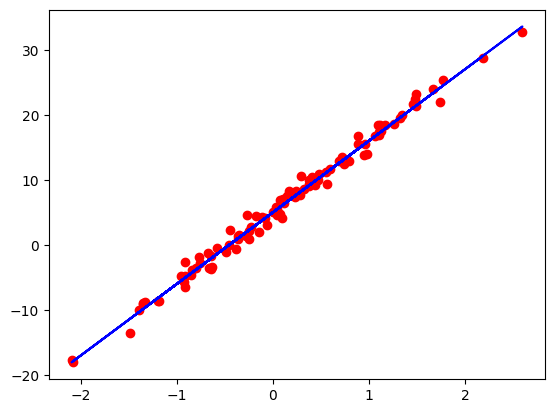

In [24]:
# Don't Modify This Cell
num_samples = 100

noise = np.random.randn(num_samples, 1)
X = np.random.randn(num_samples, 1)

y_ideal = 11*X + 5
y_real = (11*X + 5) + noise

plt.plot(X, y_real, 'ro')
plt.plot(X, y_ideal, 'b')

We see that this data is clearly regressable with a line, which, ideally, would be 11x + 5

Train a linear regression model using gradient descent, you should see that training loss goes down with the number of iterations and obtain a theta that converges to a value very close to [b, m], which in this case, for 11x + 5, would be theta = [5, 11]

Also, notice the effect of the type of regularisation on the theta obtained (after convergence) as well as the testing MSE loss. Do they make sense, given what was discussed in class?


Theta: [ 5.00108322 10.99829654]
Testing MSE Loss: 3.3649211468324996e-06



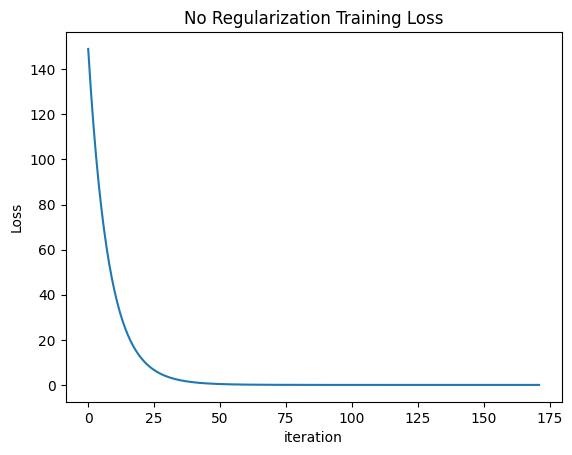


Theta: [ 5.00299183 10.98654317]
Testing MSE Loss: 0.0001519376036194355



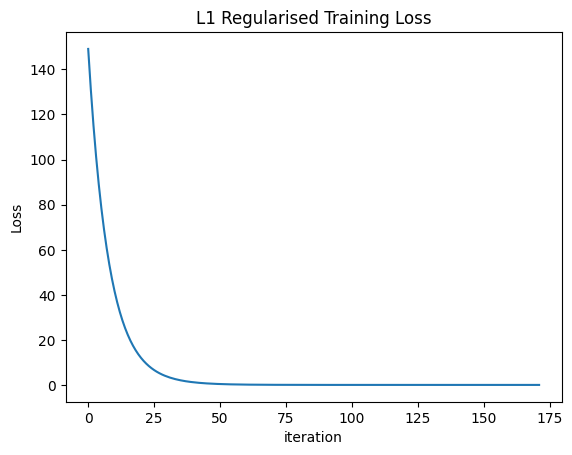


Theta: [ 5.04218996 10.7455973 ]
Testing MSE Loss: 0.05318747713098283



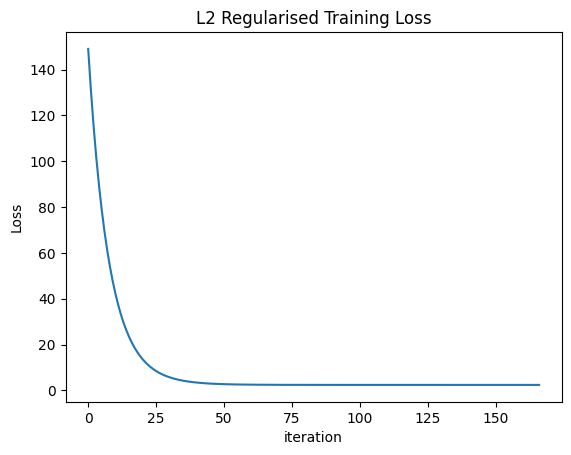

In [25]:
import sklearn
from sklearn.model_selection import train_test_split

def test_synthetic_data_sgd(X, y, n_iter = 2000, penalty=None, lambd=0):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

  alpha = 0.03  # Learning Rate

  # # Train the model
  lr_model = LinearRegression(alpha = alpha, tol=1e-4, max_iter = n_iter, penalty=penalty, lambd=lambd)
  lr_model.fit(X_train,y_train[:, 0])
  y_predict = lr_model.predict(X_test)
  loss = sklearn.metrics.mean_squared_error(y_predict, y_test)
  print()
  print("Theta: {}".format(lr_model.theta_))
  print("Testing MSE Loss: {}\n".format(loss))

  loss_history = lr_model.hist_cost_
  plt.plot(range(len(loss_history)), loss_history)
  plt.title("No Regularization Training Loss")
  plt.xlabel("iteration")
  plt.ylabel("Loss")
  if penalty == "l1":
    plt.title("L1 Regularised Training Loss")
  elif penalty == "l2":
    plt.title("L2 Regularised Training Loss")
  plt.show()

test_synthetic_data_sgd(X, y_ideal, 500)
test_synthetic_data_sgd(X, y_ideal, 500, "l1", 0.02)
test_synthetic_data_sgd(X, y_ideal, 500, "l2", 0.02)